<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/3/MLP_NN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.rc('figure', figsize=(8,4) )         # Image size


from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2 
import os, shutil


import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout
# %load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0] , True)
    print('Running on GPU ...')
else:
    print('Running on CPU ...')



Running on CPU ...


In [2]:
n_ts = 6  ## Length of each time sequence or the forcast window
n_f = 1
n_prediction = 60

# Univariate RNN

## Data
For this part, we use the sunspot data. This data contains the mean value of the number of sunspots for each month from 1749. 

You can find more information about this dataset from [SIDC](http://www.sidc.be/silso/ssngraphics). 

In [7]:
# data = pd.read_csv('monthly-sunspots.csv', index_col = 0)
import requests, io
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/monthly-sunspots.csv'
c = requests.get(url, stream=True).content
data = pd.read_csv(io.BytesIO(c), index_col = 0)

data.head()

,Sunspots
Month,
1749-01,58.0
1749-02,62.6
1749-03,70.0
1749-04,55.7
1749-05,85.0


In [8]:
data.iloc[-1]

Sunspots    33.4
Name: 1983-12, dtype: float64

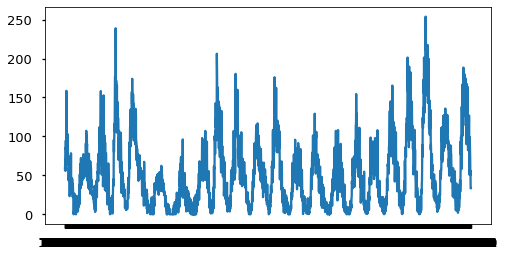

In [11]:
'''
Let's first plot the data to see if it does have a trend. 
'''

plt.plot(data.Sunspots)
plt.title = 'Sunspots in time'
plt.xlabel = 'Time (in month)'
plt.ylabel = 'Sunspots'
plt.show()

In [12]:
'''
As usuall, it is important to standardize/normalize the data. 
'''

print(f'The maximum value is {data.Sunspots.max()}')
data.Sunspots = data.Sunspots/data.Sunspots.max()

The maximum value is 253.8


### Generating the time-sequences

In [13]:
'''
The data in its current format, is not suitable for training a NN. 
We need to make the time-sequeces. 
For this, we add new columns to the dataframe and each new col 
is the same data but shifted. We create n_ts cols to collect
all the past n_ts data for each row. 
The output is a square matrix where each row is a time sequence. 
We also use the actual value as the target. 
'''
def prepare_time_seqs(data):
    output_df = pd.DataFrame()
    for i in range(n_ts):
        output_df[i] = data.Sunspots.shift(n_ts-i)
    output_df['target'] = data.Sunspots        
    return output_df


In [14]:
df = prepare_time_seqs(data)
df.head(10)

,0,1,2,3,4,5,target
Month,,,,,,,
1749-01,NaN,NaN,NaN,NaN,NaN,NaN,0.228526
1749-02,NaN,NaN,NaN,NaN,NaN,0.228526,0.246651
1749-03,NaN,NaN,NaN,NaN,0.228526,0.246651,0.275808
1749-04,NaN,NaN,NaN,0.228526,0.246651,0.275808,0.219464
1749-05,NaN,NaN,0.228526,0.246651,0.275808,0.219464,0.334909
1749-06,NaN,0.228526,0.246651,0.275808,0.219464,0.334909,0.328999
1749-07,0.228526,0.246651,0.275808,0.219464,0.334909,0.328999,0.373522
1749-08,0.246651,0.275808,0.219464,0.334909,0.328999,0.373522,0.261229
1749-09,0.275808,0.219464,0.334909,0.328999,0.373522,0.261229,0.299054


In [15]:
'''
The shift operator creates some NAN values since for the boundary, 
there's no value to be shifted forward. 
We can simply drop them. 
Note that if you want to increase n_ts, dropping the NaN values 
could result in significant data loss. 
'''
df.dropna(axis=0, inplace=True)
df.head()

,0,1,2,3,4,5,target
Month,,,,,,,
1749-07,0.228526,0.246651,0.275808,0.219464,0.334909,0.328999,0.373522
1749-08,0.246651,0.275808,0.219464,0.334909,0.328999,0.373522,0.261229
1749-09,0.275808,0.219464,0.334909,0.328999,0.373522,0.261229,0.299054
1749-10,0.219464,0.334909,0.328999,0.373522,0.261229,0.299054,0.297478
1749-11,0.334909,0.328999,0.373522,0.261229,0.299054,0.297478,0.624901


In [16]:
'''
Next we form the X and Y. 
It is important to shape X to 
(n_s, n_ts, n_f)

For this example. n_f is one. 
'''

Y = df.target.values
# Y = Y/Y.max()
X = df.drop('target', axis=1).values
print(X.shape)
X = X.reshape(-1, n_ts, n_f)
X.shape

(2814, 6)


(2814, 6, 1)

In [17]:
'''
Before generating the train and validation sets, let's 
hold a portion of the data for prediction. 
We seperate the data for the last n_prediction 
months and later test to see how well our model 
can predict the target for these months. 
'''
X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(2065, 6, 1)


## Simple non-RNN model

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2880px-Recurrent_neural_network_unfold.svg.png)


In [19]:
from tensorflow.keras.layers import LSTM, RNN, GRU, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models

In [21]:
model = models.Sequential()
model.add(layers.Flatten(input_shape =(n_ts, n_f) ))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', 
              loss=tf.keras.losses.mean_squared_error)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train,Y_train, 
                    epochs=10, batch_size = 64, 
                    verbose=1 , 
#                     callbacks=my_callbacks, 
                    validation_data = (X_test, Y_test))

Epoch 1/10
33/33 [==============================] - 1s 8ms/step - loss: 0.0122 - val_loss: 0.0049
Epoch 2/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 3/10
33/33 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 4/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 5/10
33/33 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 6/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 7/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 8/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 9/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 10/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0040


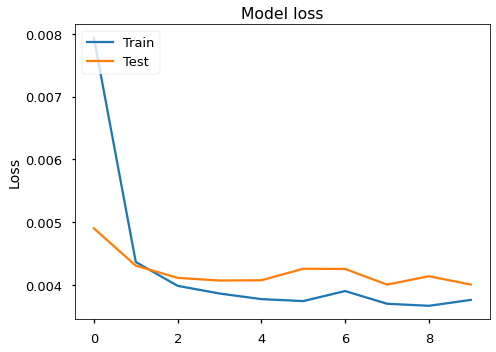

In [23]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

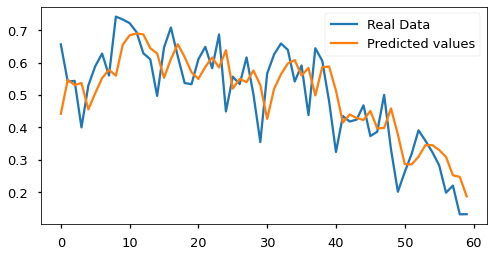

In [24]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.legend(loc=0)
plt.show()

## Simple RNN model

In [25]:
model = models.Sequential()
model.add(SimpleRNN(64, input_shape =(n_ts, n_f) , 
               activation='tanh', 
               return_sequences=True) 
         )

model.add(SimpleRNN(32,  activation='tanh')  )

model.add(Dense(32,  activation='relu')  )

model.add(Dense(1,  activation='linear')  )


model.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 6, 64)             4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 8,417
Trainable params: 8,417
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
130/130 [==============================] - 2s 6ms/step - loss: 0.0126 - val_loss: 0.0043
Epoch 2/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 3/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 4/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 5/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 6/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 7/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 8/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 9/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 10/10
130/130 [==============================] - 1s 4ms/step - loss: 0.0040 - val_loss: 0.0042

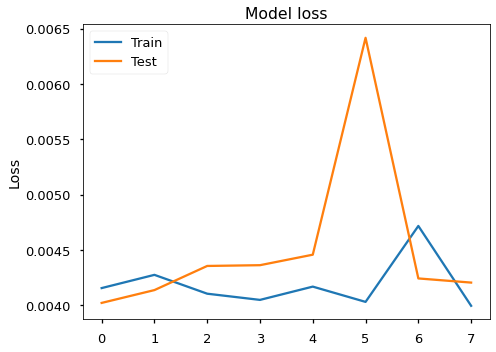

In [28]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

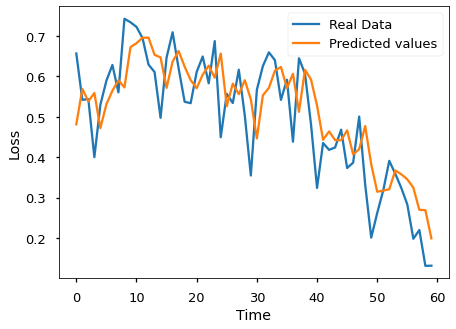

In [29]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, xlabel = 'Time', ylabel= 'Loss')

Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()

## RNN with long short term memory (LSTM)

Next, we train a LSTM model. 

For more information, see this post

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

and 

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/2880px-Long_Short-Term_Memory.svg.png)



In [30]:
model = models.Sequential()
model.add(LSTM(64, input_shape =(n_ts, n_f) , 
               activation='tanh', 
               return_sequences=True) 
         )

model.add(LSTM(32,  activation='tanh')  )

model.add(Dense(32,  activation='relu')  )

model.add(Dense(1,  activation='linear')  )


model.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )


In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=0, validation_data=(X_test, Y_test))

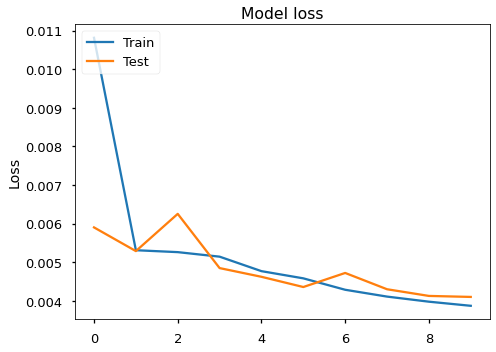

In [33]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

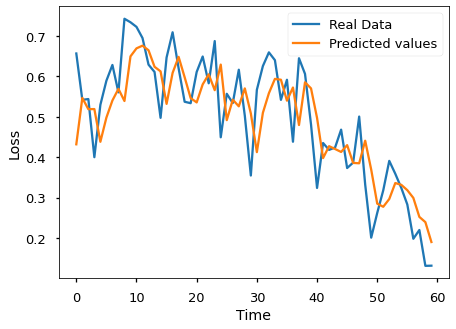

In [34]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, xlabel = 'Time', ylabel= 'Loss')

Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()

# Multivariate RNN

In [35]:
'''
Here's the data for air pollution in Beijing, taken from 
http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

Use LSTM RNN models to predict the air pollution. 

'''
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
import requests, io

c = requests.get(url, stream=True).content
data = pd.read_csv(io.BytesIO(c), index_col = 0)
data.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
'''
We probably don't need year, month, day and hour if hour is always increasing by one. 
It should be enough to keep only the index. 
'''
data.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
data.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            43815, 43816, 43817, 43818, 43819, 43820, 43821, 43822, 43823,
            43824],
           dtype='int64', name='No', length=43824)

### Dealing with nan values

In [ ]:
data.isna().any()

pm2.5     True
DEWP     False
TEMP     False
PRES     False
cbwd     False
Iws      False
Is       False
Ir       False
dtype: bool

In [ ]:
data['pm2.5'].isna().sum()

2067

In [ ]:
print(len(data))

43824


In [ ]:
'''
There are two many of them and we can't just remove those rows. 
So we replace the NaN values with the mean of the col. 
'''

data.fillna(data.mean(), inplace=True)

In [ ]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,
1,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
3,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
4,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
5,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
'''
Next we need to turn categorical values to numerical ones. 
'''
data.cbwd = data.cbwd.astype("category").cat.codes
data.head(20)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,
1,98.613215,-21,-11.0,1021.0,1,1.79,0,0
2,98.613215,-21,-12.0,1020.0,1,4.92,0,0
3,98.613215,-21,-11.0,1019.0,1,6.71,0,0
4,98.613215,-21,-14.0,1019.0,1,9.84,0,0
5,98.613215,-20,-12.0,1018.0,1,12.97,0,0
6,98.613215,-19,-10.0,1017.0,1,16.10,0,0
7,98.613215,-19,-9.0,1017.0,1,19.23,0,0
8,98.613215,-19,-9.0,1017.0,1,21.02,0,0
9,98.613215,-19,-9.0,1017.0,1,24.15,0,0


In [ ]:
'''
We also need to normalize the data. 
'''
# normalized_data=(data-data.mean())/data.std()
normalized_data=(data-data.min())/(data.max()-data.min())


In [ ]:
n_f = data.shape[1] 
n_f

8

In [ ]:
hist = range(1,n_ts+1)

df = normalized_data.assign(**{
    '{} (h-{})'.format(col, t): normalized_data[col].shift(t)
    for t in hist
    for col in normalized_data
})

df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5 (h-1),DEWP (h-1),TEMP (h-1),PRES (h-1),cbwd (h-1),Iws (h-1),Is (h-1),Ir (h-1),pm2.5 (h-2),DEWP (h-2),TEMP (h-2),PRES (h-2),cbwd (h-2),Iws (h-2),Is (h-2),Ir (h-2),pm2.5 (h-3),DEWP (h-3),TEMP (h-3),PRES (h-3),cbwd (h-3),Iws (h-3),Is (h-3),Ir (h-3),pm2.5 (h-4),DEWP (h-4),TEMP (h-4),PRES (h-4),cbwd (h-4),Iws (h-4),Is (h-4),Ir (h-4),pm2.5 (h-5),DEWP (h-5),TEMP (h-5),PRES (h-5),cbwd (h-5),Iws (h-5),Is (h-5),Ir (h-5),pm2.5 (h-6),DEWP (h-6),TEMP (h-6),PRES (h-6),cbwd (h-6),Iws (h-6),Is (h-6),Ir (h-6)
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.099208,0.279412,0.081967,0.509091,0.333333,0.016047,0.0,0.0,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.099208,0.294118,0.114754,0.490909,0.333333,0.021396,0.0,0.0,0.099208,0.279412,0.081967,0.509091,0.333333,0.016047,0.0,0.0,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.00229,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### Next we get rid of the first n_ts rows that have nan values. 
df.dropna(axis=0, inplace=True)

In [ ]:
### The target is the pollution of the day
Y = df['pm2.5'].values

### Then we get rid of all the measurements of that day. 
X = df.drop(data.columns, axis=1).values

print(X.shape)
X = X.reshape(-1, n_ts, n_f)
X.shape

(43818, 48)


(43818, 6, 8)

In [ ]:
'''
Before generating the train and validation sets, let's 
hold a portion of the data for prediction. 
We seperate the data for the last n_prediction 
months and later test to see how well our model 
can predict the target for these months. 
'''
X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(32818, 6, 8)


In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

In [ ]:
model2 = keras.models.Sequential()
model2.add(LSTM(64, input_shape =(n_ts, n_f) , 
                     return_sequences=False)  )
model2.add(Dropout(.1))

# model2.add(LSTM(32)  )
# model2.add(Dropout(.2))

model2.add(Dense(32,  activation='relu')  )
model2.add(Dropout(.2))

model2.add(Dense(1,  activation='linear')  )


model2.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )
history2 = model2.fit(X_train, Y_train, epochs=50, 
                      batch_size=16, verbose=1, 
                      validation_data=(X_test, Y_test))


Epoch 1/50
2052/2052 [==============================] - 15s 8ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 2/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0013 - val_loss: 8.4883e-04
Epoch 3/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0012 - val_loss: 9.4463e-04
Epoch 4/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0011 - val_loss: 7.7508e-04
Epoch 5/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0011 - val_loss: 8.7953e-04
Epoch 6/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0010 - val_loss: 6.9995e-04
Epoch 8/50
2052/2052 [==============================] - 15s 7ms/step - loss: 9.9189e-04 - val_loss: 7.0381e-04
Epoch 9/50
2052/2052 [==============================] - 14s 7ms/step - loss: 9.7491e-04 - val_loss: 6.9939e-04
Epoch 10/50
2052/2052 [==============

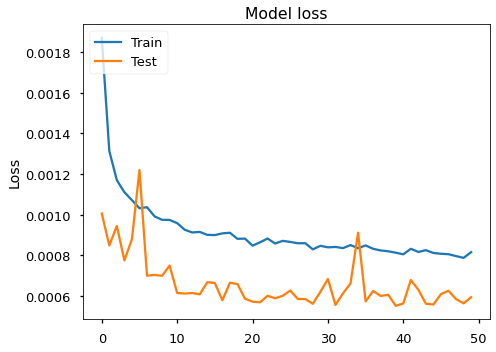

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

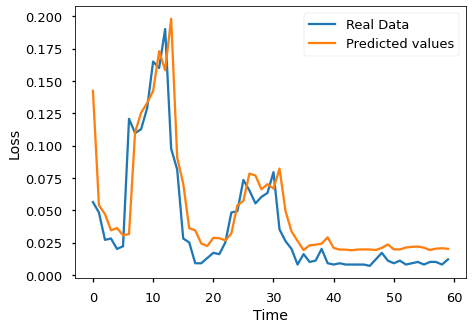

In [ ]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, xlabel = 'Time', ylabel= 'Loss')

Y_fut_predicted = model2.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()